In [1]:
import graph_tool as gt
import graph_tool.collection as gtc
import graph_tool.draw as gtd

import numpy as np
import itertools
import time


def k_parmi_n(k,n):
    """binomial coefficient k parmi n"""
    num = np.math.factorial(n)
    denom = np.math.factorial(k)*np.math.factorial(n-k)
    return num/denom

def d(w):
    """given vertex w, returns its total degree"""
    return (w.in_degree() + w.out_degree())


def S_set(w : gt.libgraph_tool_core.Vertex):
    """returns sets of vertices that forms a 2-star centered at vertex w"""
    nodes = list(w.all_neighbors())
    nb = len(nodes)
    Sw = []
    if nb >= 2: #if more then 2 surrounding node, w is part of at least one 2-star
        if (nb % 2) == 0:#pair
            Sw = list(w.all_neighbors())  #we will be careful to distinct generators and list-tuples, last two are called
        if (nb % 2) != 0: #impaire #can use else here for faster code?
            Sw = list(nodes[0:(nb-1)])
        Sw.append(w) #w is part of 2-star since it is the center of each one
    return list(Sw)

def Te_set(G : gt.Graph, e : gt.libgraph_tool_core.Edge):
    """given graph G and edge e, returns set of vertices Te that form triangles with edge e"""
    v = e.source()
    u = e.target()
    Te = []
    
    #create iterator over all vertex neighbors of v and u, remove repeated vertex, remove v and u
    ite_without_repeat = list(itertools.chain(v.all_neighbors(), u.all_neighbors()))
    for w in v.all_neighbors():
        if w in u.all_neighbors():
            ite_without_repeat.remove(w)
    ite_without_repeat.remove(u) #should remove u and v from this, otherwise we test
    ite_without_repeat.remove(v) #if u is in u and it is, but can be triangle with itself
    
    #create Te set of vertices following math definition of the set Te    
    for w in ite_without_repeat:
        if (w in v.all_neighbors()) and (w in u.all_neighbors()):
            Te.append(w)
    return(Te)

def LOCALGRAPHLET(G : gt.Graph, e : gt.libgraph_tool_core.Edge):
    """given graph G and edge e, returns graphlet G1,G2,G5,G6,G7,G8,G9,G10 degree vector of the edge"""
    #graphlet counts
    x5 = 0
    x7 = 0
    x8 = 0
    sigma = 0
    
    #lookup table is a dictionnary
    psi = dict()
    
    #vertices objects and sets of vertices objects
    v = e.source()
    u = e.target()
    Sv = S_set(v)
    Su = S_set(u)
    
    #set of edge objects
    Te = Te_set(G,e) 
    
    #count graphlets x5, x7, x8 directly in graph
    for w in v.all_neighbors():
        if w != u:
            Sv.append(w)
            psi[w] = 'lambda1'
    for w in u.all_neighbors():
        if w != v:
            if (w in psi.keys()) == True:
                if psi[w] == 'lambda1': #careful to check w is a key of dictionnary psi before calling value psi[w]
                    Te.append(w)
                    psi[w] = 'lambda3'
                    Sv.remove(w)
                    psi[w] = 'lambda2'
    for w in Te:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True:
                if psi[r] == 'lambda3':
                    x5 = x5 +1
                psi[w] = 'lambda4'
    for w in Su:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True:
                if psi[r] == 'lambda1':
                    x8 = x8 + 1
                if psi[r] == 'lambda2':
                    x7 = x7 +1
                if psi[r] == 'lambda4':
                    sigma = sigma + 1
        psi[w] = 0
    for w in Sv:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True: #is it necessary to check if r in psi.keys() here? Did we did it just before?
                if psi[r] == 'lambda1':
                    x7 = x7 + 1
                if psi[r] == 'lambda4':
                    sigma = sigma + 1
        psi[w] = 0
    
    #graphlets counts x1, x2, x6, x9, x10 deduced
    
    x1 = len(tuple(Te))
    x2 = (d(u) + d(v) - 2) - 2*len(Te) #sometimes get negative counts
    #x6 = k_parmi_n(2, len(tuple(Te))) - x5 #need to solve, (k parmi n) for n >=k, otherwise negative factorial is impossible
    #x9 = k_parmi_n(2, len(tuple(Sv))) + k_parmi_n(2, len(tuple(Sv))) - x7
    x10 = (len(tuple(Sv))*len(tuple(Su))) - x8
    
    return(np.array([x1, x2, x5, x7, x8]))




/Users/endingalaporte/Documents/python/miniconda3/envs/env/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
#import Brest's graph edgelist and create graph G of Brest
import pandas as pd

df = pd.read_csv("/Users/endingalaporte/Desktop/planning/W10_0504-1205_GRAPHLET_CENTRALITY/edgelist_brest.csv")
edge = np.array([np.array(df['0.000000000000000000e+00'].values).astype(int),
                 np.array(df['1.000000000000000000e+00'].values).astype(int)])
edge = edge.T
G = gt.Graph(directed = False)
G.add_edge_list(edge)

#get matrix

#G = graph('triangles')
#gtd.graph_draw(G, output_size = (100,100))

s = time.time()
matrix = []
for e in G.edges():
    matrix.append(LOCALGRAPHLET(G, e))
matrix = np.array(matrix)
print("duration is",time.time()-s)

display(matrix.shape)
matrix

duration is 45.96903920173645


(41802, 5)

array([[0, 3, 0, 0, 1],
       [0, 3, 0, 0, 1],
       [0, 4, 0, 1, 2],
       ...,
       [0, 4, 0, 3, 0],
       [0, 2, 0, 0, 0],
       [0, 2, 0, 0, 0]], dtype=object)

In [4]:
G

<Graph object, undirected, with 30595 vertices and 41802 edges at 0x10c1cb0a0>

calculation time is 101.41974782943726


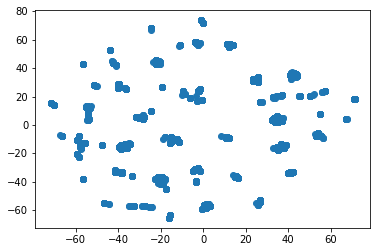

In [11]:
#reduce matrix dimension to 2D using TSNE, plot
s = time.time()

#scale 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(matrix[0:10000]) #first 10000 edges
scaled_matrix = scaler.transform(matrix[0:10000])
#embed matrix in 2D
from sklearn.manifold import TSNE
embedded = TSNE(n_components = 2).fit_transform(scaled_matrix)
import matplotlib.pyplot as plt
plt.scatter(embedded[:,0], embedded[:,1])
print("calculation time is",time.time()-s)

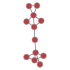

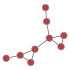

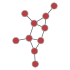

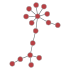

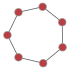

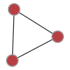

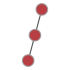

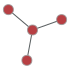

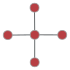

In [15]:
#graphs for beta testing LOCALGRAPHLET
graphs = [graph('triangles'),graph('line'),
          graph('siam'),graph('2star'),
          graph('circle'),graph('single_triangle'),
          graph('single_2star'), graph('single_3star'), graph('single_4star')]
for g in graphs:
    gtd.graph_draw(g, output_size = (70,70))

non


['chose']

[2, 1, 3, 4, 1]

[2, 3, 4, 1]

[2, 3, 4]

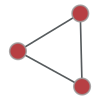

[<Vertex object with index '1' at 0x166cebf90>,
 <Vertex object with index '2' at 0x166ceb690>,
 <Vertex object with index '0' at 0x166b833f0>]

In [13]:
#TRASH 

#specific graphs for testing

def graph(t):
    """given string type of graph, returns graph type"""
    G = gt.Graph(directed = False)
    if t == 'triangles':
        G.add_edge_list([(0,1),(1,2),(2,0),(2,3),
                         (3,4),(4,2),(4,5),(5,2),
                         (6,7),(7,8),(6,8),(6,9),
                         (9,8),(6,10),(10,8),(4,11),
                         (11,6)])
    if t == 'line':
        G.add_edge_list([(1,2),(2,3),(3,4),(4,2),(4,5),(5,6),(6,7),(7,5),(5,8),(8,0)])
    if t == 'siam':
        G.add_edge_list([[0, 1],[1, 2],[1, 3],[2, 4],
                         [2, 5],[3, 2],[3, 6],[5, 8],
                         [5, 7],[6, 7],[6, 5],[7, 9]])
    if t == '2star':
        G.add_edge_list([(1,2),(2,3),(3,4),(3,5),
                         (3,6),(3,7),(3,8),(3,9),
                         (3,10),(10,11),(11,13),
                         (12,13),(13,14),(13,15),
                         (15,0)])
    if t == 'circle':
        G.add_edge_list([(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,0)])
    if t == 'single_triangle':
        G.add_edge_list([(0,1),(1,2),(2,0)])
    if t == 'single_2star':
        G.add_edge_list([(0,1),(1,2)])
    if t == 'single_3star':
        G.add_edge_list([(0,1),(1,2),(1,3)])
    if t == 'single_4star':
        G.add_edge_list([(0,1),(1,2),(1,3),(1,4)])
    return G

#if else pas égale
a = 1
b = 0
if a != b:
    print("non")
else:
    print("égal")

#si on a une liste, peut on mettre à jour cette liste par une forme plus proche de la syntaxe du code du paper
#i.e. pas liste.append(chose) mais liste = liste.append(chose) ? Non car liste.append() revoit un NoneType

liste = []
liste.append('chose')

#can remove element from liste 

liste = []
liste.append('chose')
display(liste)
liste.append('truc')
liste.remove('chose')
liste

#objects can be keys in dictionnaries

G = graph('siam')
e = tuple(G.edges())[0]

#call first and second vertex object in edge object that way
e, e.source(), e.target()

#can call edge object in these two same ways

tuple(G.edges())[0] == list(G.edges())[0]

#dictionnary is a lookup table 
e1 = tuple(G.vertices())[1]
e2 = tuple(G.vertices())[2]
e3 = tuple(G.vertices())[3]
e4 = tuple(G.vertices())[4]

table = dict()
table[e1] = 'lambda1'
table[e2] = 'lambda2'

table[e4] = 'lambda3' #add to lookup table

table[e4] == 'lambda3' #test value

#returns pair number liste of elements

liste = [0,1,2,3,4,5]

long = len(liste)
S = []
if long % 2 == 0: #pair
    S = liste
if long % 2 != 0: #impair
    S = liste[0:long-1]

#remove method removes first matching value in list from left

l = [1,2,1,3,4,1]

l.remove(1)
display(l)
l.remove(1)
display(l)
l.remove(1)
display(l)


#checking S_set

G = graph('single_triangle')
gtd.graph_draw(G, output_size = (100,100))
#e = tuple(G.edges())[1]
v = tuple(G.vertices())[0]

S_set(v)